## **Note**
#####  This material is mainly aiming to crystallize my knowledge. Any suggestion or correction will be gladly accepted
<br>
This notebook contains an experiment on Precision-Recall and ROC metrics for classification tasks. When trying to understand how well a classification network performs, the accuracy metric doesn't provide much insight. Also, it is important to understand that the threshold involves more information than just setting the value which defines a sample as part of a class or not. 
The ROC and Precision-Recall curves are two useful tools to analyze a classification network and optimize it for the task to solves.


<br><br>
If you want to get more insights I suggest you read the following posts:
- Jason Brownlee: https://goo.gl/Wga72c
- developers.google.com: https://goo.gl/g4Xd92
- Hands-On Machine Learning zith Scikit-Learn & tensorflow, Aurélien Géron
- Receiver operating characteristic: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
- Precision and recall: https://en.wikipedia.org/wiki/Precision_and_recall 
- The relationship between Precision-Recall and ROC curves:https://dl.acm.org/citation.cfm?id=1143874
The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets


## Experiment
To experiment around those metrics, I built a small dataset that contains two distinct shapes. The network should solve the task of classifying rectangles as 1 (rectangle) and circles as 0 (circle). It will then allows us to easily look at the two metrics.

In [1]:
import cv2
import numpy as np
import keras.utils as KU
import keras.layers as KL
import keras.utils as KU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras import metrics

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\vincent.local\Anaconda3\envs\py\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [2]:
class Config():
    """Configuration 
    """
    IMG_SIZE = 128
    
    EPOCHS = 5
    
config = Config()

## **Dataset**
<br>
For simplicity I will reuse a part of the artificial dataset created for this notebook: 

https://github.com/vincentlorant/Multi_outputs_network/blob/master/multi_outputs_network.ipynb

In [3]:
def random_shape(img, r_shapes, i):
    '''Draw a rectangle or a circle with random coordinates
    and a random color
    '''
    if(r_shapes[i] == 0):
        coord = np.random.randint(config.IMG_SIZE, size=(1, 2))
        size = np.random.randint(40, size=1)
        
        cv2.circle(img,(
            coord[0][0],coord[0][1]), 
                   size[0] +10, 
                   (255,255,255), -1)
        
    elif(r_shapes[i] == 1):
        center = np.random.randint(config.IMG_SIZE//2, size=2)+30
        coord = np.random.randint(config.IMG_SIZE//3, size=4)
        
        cv2.rectangle(img,
                      (center[0] - coord[0],center[1] - coord[1]),
                      (center[0] + coord[2],center[1] + coord[3]),
                      (255,255,255), 
                      thickness  = 3)

        
def create_data(nbr = 60):
    '''Build toy dataset
    Note: It seems that even when doing binary classification, 
    using One hot encoding gives better results (not used here).
    '''
    r_shapes = np.random.randint(2, size=nbr) 
    y_shape = list(r_shapes)# KU.to_categorical(list(r_shapes))
    data = np.empty((0,config.IMG_SIZE,config.IMG_SIZE,3))
    
    for i in range(nbr):
        img = np.zeros((config.IMG_SIZE,config.IMG_SIZE,3), np.uint8)
        random_shape(img, r_shapes, i)
        img = np.expand_dims(img, 0)
        data = np.append(data, img, axis=0)
    
    return data, r_shapes

x, y =  create_data(250)

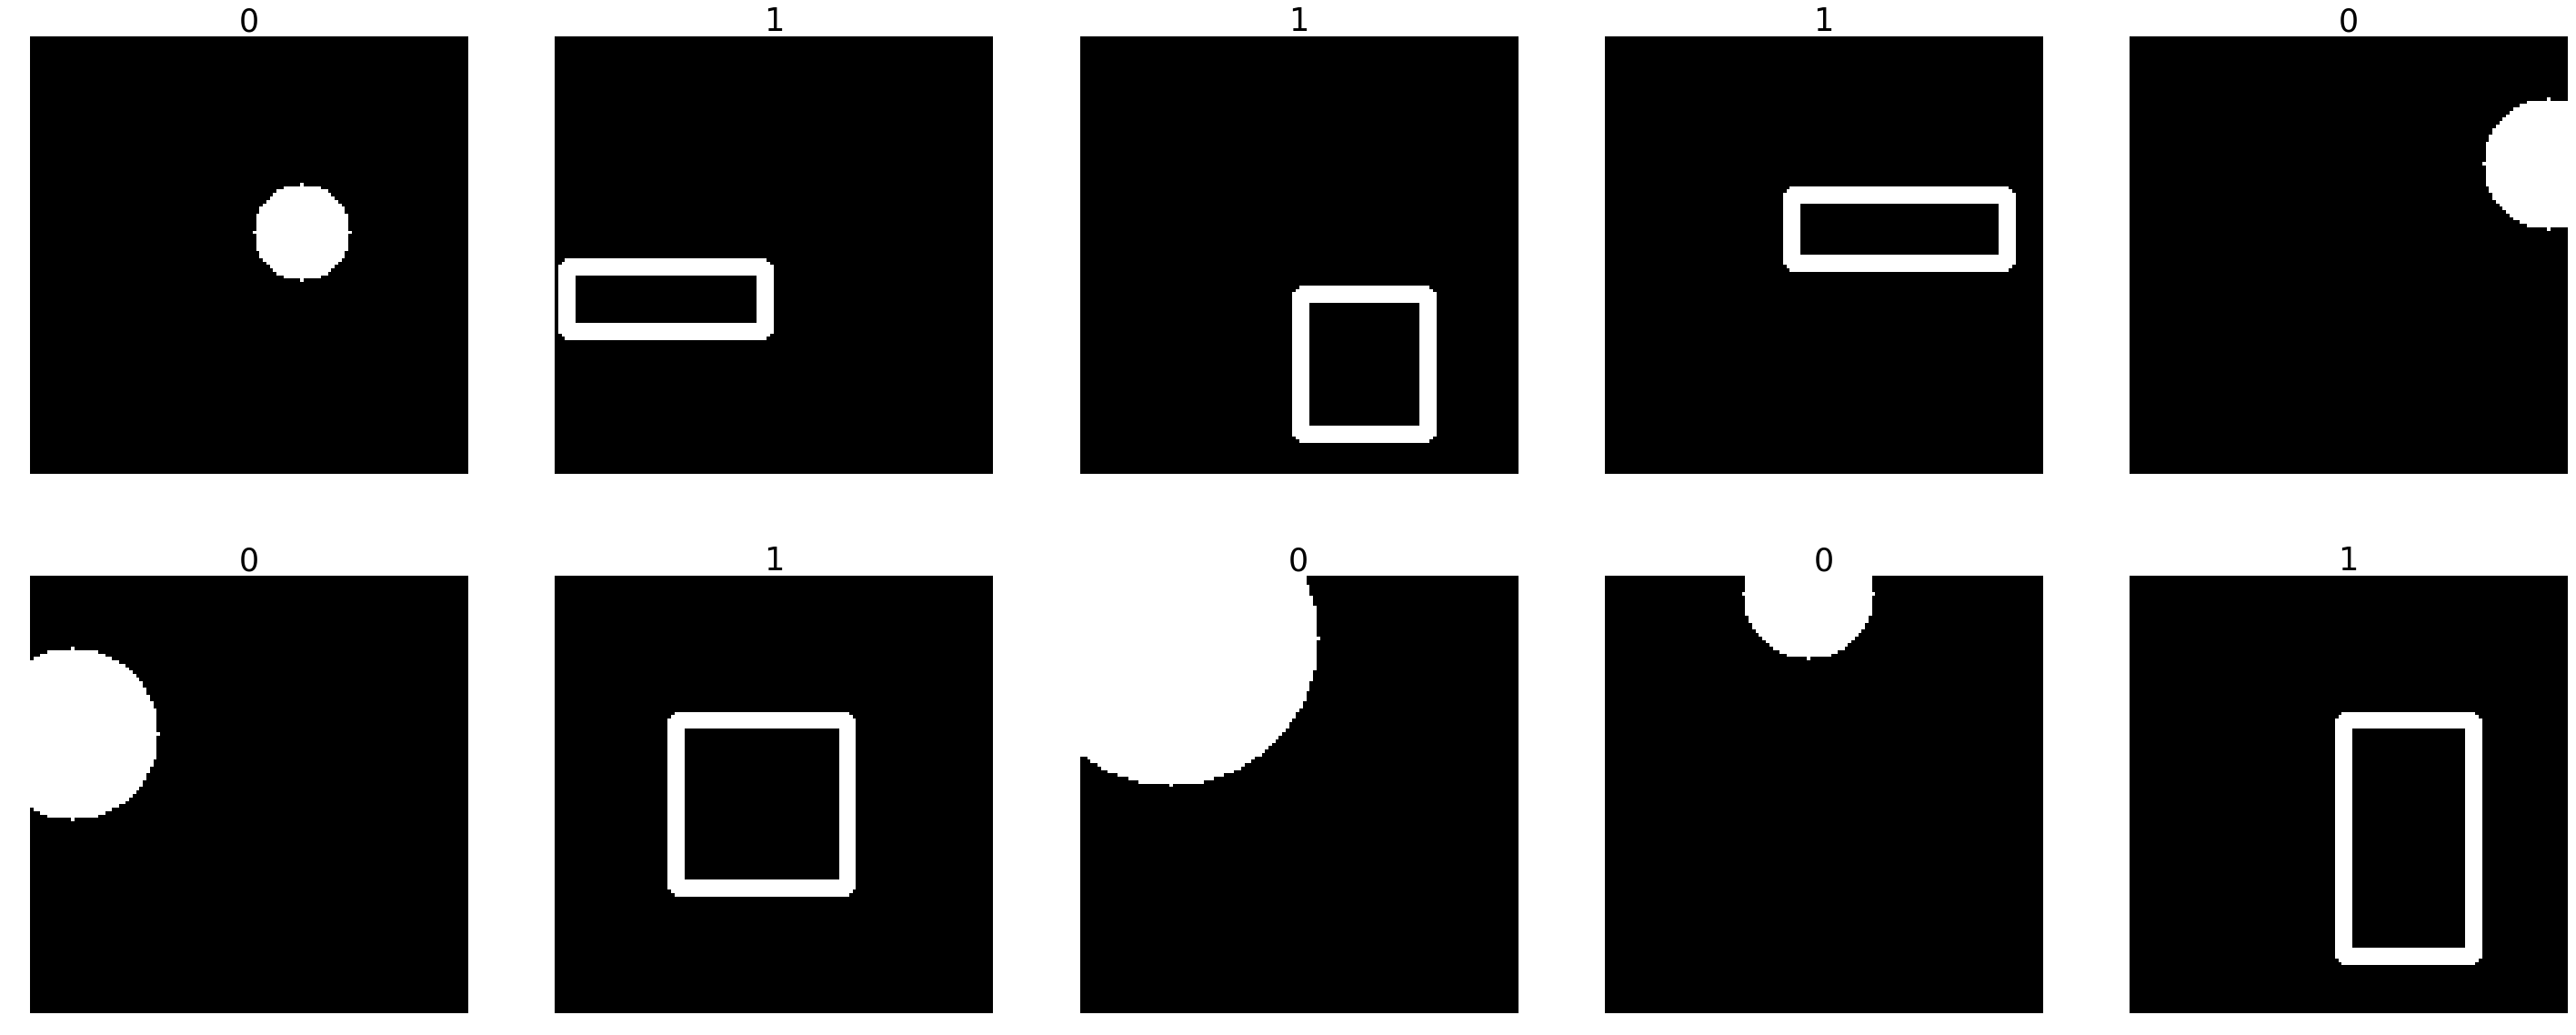

In [4]:
def display_random_data(data, y, rows):
    '''Display randomly selected samples from the toy dataset
    '''
    idx = np.random.randint(data.shape[0], size=rows*4)
    fig, axarr = plt.subplots(2, rows, figsize=(rows*10, rows*4))

    for i in range(1,rows*2+1):
        
        sample = idx[i]
        img = data[sample]/255
        title = y[sample]
        
        axarr[i//(rows+1),i%rows].imshow(img)
        axarr[i//(rows+1),i%rows].set_title(title, fontsize=35)
        axarr[i//(rows+1),i%rows].axis('off')
        
display_random_data(x, y, 5)

## **Model**

In [5]:
def build_model():
    '''Build model use Keras Sequential API
    '''
    Inputs = (config.IMG_SIZE, config.IMG_SIZE, 3)
    model = Sequential()
    
    model.add(KL.Conv2D(32, kernel_size=(3, 3),input_shape=Inputs))
    model.add(KL.Activation('relu'))
    model.add(KL.BatchNormalization())       
    model.add(KL.MaxPooling2D((2, 2)))       
    model.add(KL.Dropout(0.25))
    
    model.add(KL.Flatten())
    model.add(KL.Dense(64))
    model.add(KL.Activation('relu'))
    
    model.add(KL.Dense(1))
    model.add(KL.Activation('sigmoid'))
              
    return model
        

def prepare_model(model):
    '''Compile model
    '''
    model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
                      loss='binary_crossentropy',
                      metrics=[metrics.binary_accuracy])

    
def train_model(model, data, y):
    '''Train model
    '''
    H = model.fit(
        data,
        y,
        epochs=config.EPOCHS,
        batch_size=16)

    return H

In [6]:
model = build_model()
prepare_model(model)
H = train_model(model, x,y)

Epoch 1/5
250/250 [==============================] - 2s 8ms/step - loss: 1.5103 - binary_accuracy: 0.7280
Epoch 2/5
250/250 [==============================] - 0s 1ms/step - loss: 0.3803 - binary_accuracy: 0.9200
Epoch 3/5
250/250 [==============================] - 0s 1ms/step - loss: 0.2160 - binary_accuracy: 0.9640
Epoch 4/5
250/250 [==============================] - 0s 1ms/step - loss: 0.1602 - binary_accuracy: 0.9880
Epoch 5/5
250/250 [==============================] - 0s 1ms/step - loss: 0.0781 - binary_accuracy: 0.9920


## **Metrics**
Let's start looking at metrics by predicting samples from a new dataset.

In [7]:
x_test, y_test =  create_data(500)

scores = []
for i in range(len(x_test)):
    sample = np.expand_dims(x_test[i], axis=0)
    p = model.predict(sample)[0]
    '''putting a threshold will make a ROC curve with only one middle vertex 
    p = 0 if p < 0.5 else 1
    '''
    scores.append(p)

## **ROC**
#### The ROC (receiver operating characteristic) curve is a nice tool that plots the true positive rate (TPR) against the false positive rate(FPR). We can see below that the ROC curve display the following tradeoff: the higher the TPR is, the more false positives will be produced by the classifier. Depending on the problem/task it is trying to solve, one of the rates might be more important than the other.
<br>
TPR = TP / (TP + FN)
<br>
*The true positive rate is stands for how good the model is to predict actual positive as positive.*
<br><br>
FPR = FP / (FP + TN)
<br>
*The false positive rate stands for the ratio of negative instances that are incorrectly classified as positive.*

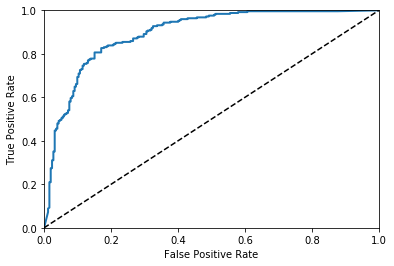

In [8]:
#Code from handson machine learning
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

A good way to compare such classifier is to look at the area under the curve(AUC). Random predictions would lead to a AUC value of 0.5 while a model perfectly classifying data would lead to a AUC value of 1.

In [9]:
roc_auc_score(y_test, scores)

0.8937852022529443

*In that case, the task is really easy for the network and training on more examples would definitely push the blue curve to the top left corner meaning perfect classification on all samples. In practice, it might be hard or impossible to get those perfect predictions. Looking at the curve make it easy to choose a good tradeoff for the task to solve.*

## **Precision - Recall**
#### The ROC curve is usually used to look at how well a binary classifier performs but it might be deceptive in specific cases such as a situation where your dataset is unbalanced and contains more samples in one of the classes. Another good tool which gives more insight, in that case, is the Precision-Recall curve. Here again, it is a tradeoff between how accurate you want your model to output positive value when it's actually positive with how many positive you want to detect even if it includes more negative as positive.

<br>
P = TP / (TP + FP)
<br>
The precision shows how good the model is at predicting positive class
<br><br>
R = TP / (TP + FP)
<br>
The recall gives you the ratio of how many truly relevant result are returned.

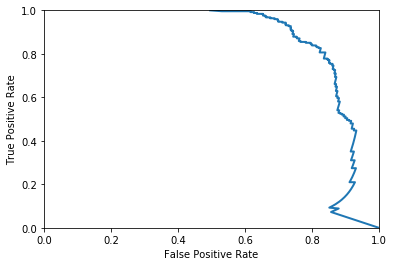

In [10]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_test, scores)

def plot_precision_recall(precision, recall, label=None):
    plt.plot(precision, recall, linewidth=2, label=label)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    
plot_precision_recall(precision, recall)
plt.show()
  


We can guess from the plot the more the curve is closed to the top right corner, the better the model's predictions are. <br><br>

### "If someone says “let’s reach 99% precision,” you should ask, “at what recall?”"
*Handson machine learning